# Test point assigner

* Code partially taken from [Oriented RepPoints](https://github.com/LiWentomng/OrientedRepPoints/tree/main/mmdet/ops).

In [70]:
%reload_ext autoreload
%autoreload 2

import time
import torch
import torchvision
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from random import randint

from obb.utils.box_ops import *
from obb.model.oriented_reppoints_loss import *
from obb.utils.dataset import Dataset

In [68]:
# Load sample image
img_idx = 2

train_dataset = Dataset(path='../assets/DOTA_sample_data/split')
train_data_loader = DataLoader(train_dataset, batch_size=1, shuffle=False)

for idx, (curr_img, curr_obb, curr_object_class) in enumerate(train_data_loader):
    if idx == img_idx:
        img, obb, object_class = curr_img, curr_obb.squeeze(), curr_object_class.squeeze()
        break

print(img.shape)

torch.Size([1, 3, 512, 512])


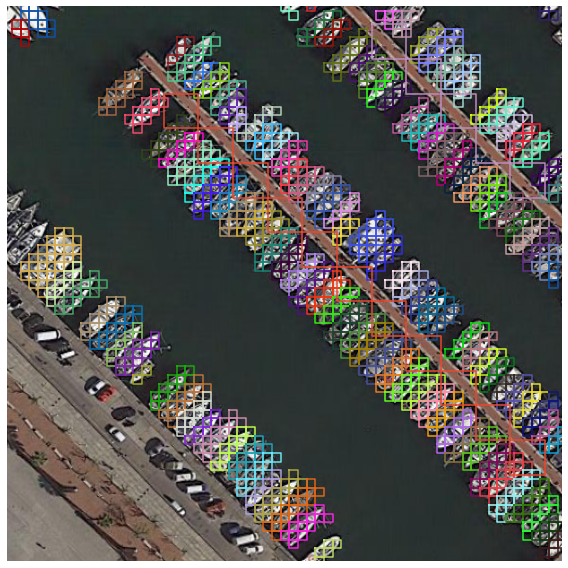

In [81]:
# Assign cells in feature maps to gt objects
b, xy, (h, w) = 1, 18, img.shape[2:]
lvls = [3, 4, 5]
strides = [2 ** lvl for lvl in lvls]
colors = ['#%06X' % randint(0, 0xFFFFFF) for _ in obb]
stride_dict = {f'P{lvl}': stride for lvl, stride in zip(lvls, strides)}
feature_map_dict = {f'P{lvl}': torch.rand(b, xy, h, w) for lvl in lvls}

model_loss = OrientedRepPointsLoss(stride_dict)
assigner = SimpleAssigner()

centers, _ = model_loss._get_centers(feature_map_dict, feature_map_dict)
assigned_gt_idxs, assigned_labels = assigner.assign(centers, obb, object_class)

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1)
for i in range(len(centers)):
    if assigned_labels[i] != 0:
        x, y, stride = centers[i]
        square = torch.Tensor([[x - 0.5 * stride, y - 0.5 * stride],
                               [x + 0.5 * stride, y - 0.5 * stride],
                               [x + 0.5 * stride, y + 0.5 * stride],
                               [x - 0.5 * stride, y + 0.5 * stride]])
        ax.plot(torch.cat((square[:, 0], square[0, 0].reshape(1))), torch.cat((square[:, 1], square[0, 1].reshape(1))), color=colors[assigned_gt_idxs[i] - 1])

ax.imshow(img.squeeze().permute(1, 2, 0).numpy())
ax.set_axis_off()
plt.tight_layout()